# LSTM 

Resources: 

http://colah.github.io/posts/2015-08-Understanding-LSTMs/

https://medium.com/analytics-vidhya/beginners-guide-to-stock-prediction-using-lstm-7010bf8b8c21

https://towardsdatascience.com/deep-learning-model-interpretation-using-shap-a21786e91d16

https://machinelearningmastery.com/reshape-input-data-long-short-term-memory-networks-keras/

https://github.com/MohammadFneish7/Keras_LSTM_Diagram


## Imports

interim

In [39]:
import os
import time
import pandas as pd
import numpy as np
import pickle
import shapely
import random

# import cartopy #Was throwing an error, couldn't tell you why?
# import cartopy.crs as ccrs
# import cartopy.feature as cfeature
# from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
# import cartopy.io.img_tiles as cimgt
import matplotlib.pyplot as plt
# import cartopy.mpl.geoaxes

import mpl_scatter_density # adds projection='scatter_density'
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from scipy.io import loadmat

import sklearn.metrics as skm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.preprocessing.sequence import TimeseriesGenerator

import tensorflow as tf
from tensorflow import keras

In [143]:
#Set up all lat/lon pairs that we will be transforming into arrays:
def latlon_setup(df, n_input):
    pixel_counts = df.groupby(['lat', 'lon']).size() #Counts
    pixel_counts = pixel_counts.reset_index()
    #Remove lat/lon sets that don't have enough records, as defined by our n_input variable
    latlon = pd.lreshape(pixel_counts[pixel_counts[0] > (n_input -1)][['lat', 'lon']], {'lat':['lat'], 'lon':['lon']})
    latlon = latlon.drop_duplicates()
    #Make sure that we aren't sampling in a pattern:
    latlon = latlon.sample(frac = 1, random_state = 0)
    print("Length of df of unique latlon paris that meet cutoff: ", len(latlon)) #if 60: 123873, if 80: 85603
    return latlon

In [144]:
def rand_gen_np(df, n_input):
  """Returns random windows of input data at 1/10th rate """
  all_windows = list(range(len(df) - n_input + 1)) #List of total number of records in the dataframe minus the n_input window size
  n_samples = int(((len(df) - n_input + 1)/10) + 1) #all windows large enough not to be weeded out get at least one sample
  # make slices of data
  Xs, ys = [], []

  for w in range(n_samples): #For every sample we want to take:
      window = random.choice(all_windows) #Randomly select which window to take
      all_windows.remove(window) #Remove selection from list to prevent resampling
      current_slice = df.iloc[window:window+n_input]
      X = current_slice[['snowtemp', 'soiltemp', 'omega', 'Tbh', 'Tbv', 'cf', 'h']].values
      y = current_slice[['density', 'voc']].values[-1]
      Xs.append(X)
      ys.append(y)

  X = np.stack(Xs)
  y = np.stack(ys)
  return X, y

In [145]:
#What about using only numpy to pre-process?
# https://stackoverflow.com/questions/66353849/confusions-about-the-input-shape-in-lstm-models

def gen_np(df, n_input):
  """Produces sequential windows of n_input historical records of data from the provided dataframe."""
  num_windows = len(df) - n_input + 1
  # make slices of data
  Xs, ys = [], []

  for w in range(num_windows):
      current_slice = df.iloc[w:w+n_input]
      X = current_slice[['snowtemp', 'soiltemp', 'omega', 'Tbh', 'Tbv', 'cf', 'h']].values
      y = current_slice[['density', 'voc']].values[-1]
      Xs.append(X)
      ys.append(y)

  X = np.stack(Xs)
  y = np.stack(ys)
  return X, y

In [152]:
def data_prep(bigdf, latlon, path, n_input, n_features, X, y, counter = 0, savept = 0):
    start = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
    print("Started at: ", start)
    for i in range(len(latlon)-counter): #Iterate though our set of viable lat/lons, minus counter to restart if needed.
      counter += 1
      df = bigdf[(bigdf['lat'] == latlon['lat'].iloc[i]) & (bigdf['lon'] == latlon['lon'].iloc[i])] #Make a sub df of each lat/lon pair
      df = df.sort_values(by = 'date') #Make sure we have our values correctly ordered
      X2, y2 = rand_gen_np(df, n_input) #Make your arrays, in this case random
      #print("Dimensions: ", X2.shape, y2.shape)
      X = np.vstack([X, X2]) #Append your arrays
      y = np.concatenate([y, y2])
      if counter%10000 == 0: #For every ten thousand lat/long pairs acts as check point
        print("Counter: ", counter, ", Shape X: ", X.shape, time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
        with open((path + str(savept) + '.npy'), 'wb') as f: #Saves two arrays in same file, arrays can be opened separately.
          np.save(f, X)
          np.save(f, y)
        print("Wipeout: ", savept)
        savept += 1
        X = np.empty([0, n_input, n_features])
        y = np.empty([0,2])
    print("Save last: ")
    with open((path + '_last.npy'), 'wb') as f: #final save of X,y to grab any remaining lat/lon pairs since last checkpoint:
          np.save(f, X)
          np.save(f, y)
    print("Done! And it only took from ", start, " to ", time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))

In [147]:
#X_test = np.empty([0, n_input, n_features])
#y_test = np.empty([0,2])
#path = 'LSTM_Data_60Sparse_Test'
def assemble_test(X_test, y_test, path):
    for filename in os.listdir(path):
        p = os.path.join(path, filename)
        with open(p, 'rb') as f:
            X_load = np.load(f)
            y_load = np.load(f)
        X_test = np.vstack([X_test, X_load]) #Append
        y_test = np.concatenate([y_test, y_load])
        print("Test: ", f, X_test.shape)
    return X_test, y_test

In [154]:
#X_train = np.empty([0, n_input, n_features])
#y_train = np.empty([0,2])
#X_val = np.empty([0, n_input, n_features])
#y_val = np.empty([0,2])
#path = 'LSTMData80Sparse'
#switch = int(len(os.listdir(path))*.2)
def assemble_train(X_train, y_train, X_val, y_val, path, switch):
    filecount = len(os.listdir(path))
    for filename in os.listdir(path):
        filecount = filecount-1
        f = os.path.join(path, filename)
        if filecount > switch:
            print(f)
            with open(f, 'rb') as f: #Saves two arrays in same file, arrays can be opened separately or together.
                X_load = np.load(f)
                y_load = np.load(f)
            X_train = np.vstack([X_train, X_load]) #Append your arrays
            y_train = np.concatenate([y_train, y_load])
            print("Train: ", f)
        else:
            with open(f, 'rb') as f: #Saves two arrays in same file, arrays can be opened separately or together.
                X_load = np.load(f)
                y_load = np.load(f)
            X_val = np.vstack([X_val, X_load]) #Append your arrays
            y_val = np.concatenate([y_val, y_load])
            print("Val: ", f)
    return X_train, y_train, X_val, y_val

In [150]:
#https://towardsdatascience.com/choosing-the-right-hyperparameters-for-a-simple-lstm-using-keras-f8e9ed76f046

#Adam has a default of learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999, amsgrad = False.

def model_lstm():
  model = keras.models.Sequential()
  #1st layer:
  model.add(keras.layers.LSTM(60, activation='relu', return_sequences=True, input_shape=(n_input, n_features)))
  model.add(keras.layers.Dropout(0.2))
  #2nd layer:
  model.add(keras.layers.LSTM(60))
  model.add(keras.layers.Dropout(0.2))
  #Output layer:
  model.add(keras.layers.Dense(2))
  model.compile(optimizer='adam', loss='mean_squared_error')
  #model.summary()
  return(model)



In [149]:
def get_metrics(y_test, y_pred):
    mae = skm.mean_absolute_error(y_test[:,0], y_pred[:,0])
    mse = skm.mean_squared_error(y_test[:,0], y_pred[:,0])
    rmse = skm.mean_squared_error(y_test[:,0], y_pred[:,0], squared = False)
    r2 = skm.r2_score(y_test[:,0], y_pred[:,0])
    print("Snow Density Performance: ")
    print("MAE: ", mae)
    print("MSE: ", mse)
    print("RMSE: ", rmse)
    print("R2: ", r2)

    mae2 = skm.mean_absolute_error(y_test[:, 1], y_pred[:, 1])
    mse2 = skm.mean_squared_error(y_test[:, 1], y_pred[:, 1])
    rmse2 = skm.mean_squared_error(y_test[:, 1], y_pred[:, 1], squared=False)
    r22 = skm.r2_score(y_test[:, 1], y_pred[:, 1])
    print("VOD Performance: ")
    print("MAE: ", mae2)
    print("MSE: ", mse2)
    print("RMSE: ", rmse2)
    print("R2: ", r22)

    return mae, mse, rmse, r2, mae2, mse2, rmse2, r22

## Data Prep Example

In [ ]:
# #DataPrep: Scaling
# data = pd.read_parquet('/content/drive/Shareddrives/AI For Earth/Datasets/processed_data_with_datetime.parquet')
# scaler = MinMaxScaler() 
# data_scaled = data[['density', 'snowtemp', 'soiltemp', 'omega', 'Tbh', 'Tbv', 'cf', 'h', 'voc']] #We want lat, lon and date unscaled, as these will be used for sorting, not training. 
# data_scaled = pd.DataFrame(scaler.fit_transform(data_scaled), columns=data_scaled.columns)
# data_scaled['lat'] = data['lat']
# data_scaled['lon'] = data['lon']
# data_scaled['date'] = data['date']
# display(data_scaled.head())
# data_scaled.to_parquet('/content/drive/Shareddrives/AI For Earth/Datasets/scaled_processed_data_LatLonDateUnscaled.parquet')
# del(data)
# # Test/Train split:
# train_scaled = data_scaled[data_scaled['date']<'2020-01-01']
# display(train_scaled.tail())
# train_scaled.to_parquet('/content/drive/Shareddrives/AI For Earth/Datasets/train_scaled_LatLonDateUnscaled.parquet')
# del(train_scaled)
# test_scaled = data_scaled[data_scaled['date']>='2020-01-01']
# display(test_scaled.head())
# test_scaled.to_parquet('/content/drive/Shareddrives/AI For Earth/Datasets/test_scaled_LatLonDateUnscaled.parquet')
# del(test_scaled)
# del(data_scaled)

In [ ]:
# Import data:
train = pd.read_parquet('train_scaled_LatLonDateUnscaled.parquet')

print(train.columns)

print(train['date'].max())
print(train['date'].min())
print(len(train))
print(train.info())
train.head()

Index(['density', 'snowtemp', 'soiltemp', 'omega', 'Tbh', 'Tbv', 'cf', 'h',
       'voc', 'lat', 'lon', 'date'],
      dtype='object')
2019-12-31 00:00:00
2019-01-01 00:00:00
18329587
<class 'pandas.core.frame.DataFrame'>
Int64Index: 18329587 entries, 0 to 18329586
Data columns (total 12 columns):
 #   Column    Dtype         
---  ------    -----         
 0   density   float64       
 1   snowtemp  float64       
 2   soiltemp  float64       
 3   omega     float64       
 4   Tbh       float64       
 5   Tbv       float64       
 6   cf        float64       
 7   h         float64       
 8   voc       float64       
 9   lat       float64       
 10  lon       float64       
 11  date      datetime64[ns]
dtypes: datetime64[ns](1), float64(11)
memory usage: 1.8 GB
None


,density,snowtemp,soiltemp,omega,Tbh,Tbv,cf,h,voc,lat,lon,date
0,0.166630,0.908916,0.998302,0.779338,0.710750,0.708752,0.305672,0.124832,0.240164,62.684110,-160.44087,2019-01-01
1,0.176869,0.955726,0.995804,0.783470,0.715650,0.708749,0.311526,0.123756,0.228918,62.532246,-160.44087,2019-01-01
2,0.180525,0.959748,0.996218,0.790908,0.722035,0.714708,0.322348,0.123569,0.242246,62.381150,-160.44087,2019-01-01
3,0.183057,0.966050,0.996963,0.790081,0.721543,0.716810,0.302173,0.123513,0.240669,62.230810,-160.44087,2019-01-01
4,0.167732,0.926476,0.995828,0.789999,0.709735,0.705815,0.303099,0.123518,0.239886,62.684110,-160.34750,2019-01-01


Whatever we pick as n_input (number of historical records) will be our cutoff value - any pixels that have fewer than n_input records can not be run. 

If we were to set n_input to three, we would go from 467957 pixels to 428025. A minimal loss. 

Similar to this problem: 
https://stackoverflow.com/questions/61177311/creating-a-timeseriesgenerator-with-multiple-inputs

In [ ]:
n_input = 3 #how many samples/rows/timesteps to look in the past in order to forecast the next sample

pixel_counts = train.groupby(['lat', 'lon']).size()
pixel_counts = pixel_counts.reset_index()
print(pixel_counts.head())

#There are 467957 pixel locations in our set. Get all unique pairs of lat lon:

print(pixel_counts[pixel_counts[0] > n_input])
print(len(pixel_counts[pixel_counts[0] > n_input]))

latlon = pd.lreshape(pixel_counts[pixel_counts[0] > n_input][['lat', 'lon']], {'lat':['lat'], 'lon':['lon']})

latlon = latlon.drop_duplicates()
print(len(latlon))
latlon.head()

         lat        lon  0
0 -54.977610 -67.920130  1
1 -54.855858 -67.826770  3
2 -54.855858 -67.733406  2
3 -54.855858 -67.546684  2
4 -54.855858 -67.453316  1


,lat,lon,0
10,-54.73447,-68.106850,5
11,-54.73447,-68.013490,5
12,-54.73447,-67.826770,5
13,-54.73447,-67.733406,4
15,-54.73447,-67.546684,4
...,...,...,...
467952,81.24827,-19.559128,5
467953,81.24827,-19.465767,5
467954,81.24827,-19.372406,5
467955,81.24827,-19.279045,5


413624
413624


,lat,lon
0,-54.73447,-68.106850
1,-54.73447,-68.013490
2,-54.73447,-67.826770
3,-54.73447,-67.733406
4,-54.73447,-67.546684


In [ ]:
#Try getting all values for a specific lat/lon pair:
train1 = train[(train['lat'] == latlon['lat'].iloc[0]) & (train['lon'] == latlon['lon'].iloc[0])]
print(len(train1))
print(train1['date'].min())
print(train1['date'].max())
print(train1.head())
#Looks good. 

#Get all values for a second lat/lon pair:
train2 = train[(train['lat'] == latlon['lat'].iloc[1]) & (train['lon'] == latlon['lon'].iloc[1])]
print(len(train2))
print(train2['date'].min())
print(train2['date'].max())
print(train2.head())

5
2019-08-11 00:00:00
2019-08-19 00:00:00


,density,snowtemp,soiltemp,omega,Tbh,Tbv,cf,h,voc,lat,lon,date
13562138,0.412166,0.816258,0.998811,0.7,0.668379,0.677059,0.319354,0.133275,0.703391,-54.73447,-68.10685,2019-08-11
13563663,0.417339,0.805035,0.996234,0.7,0.678995,0.684643,0.319354,0.133275,0.703552,-54.73447,-68.10685,2019-08-12
13565561,0.428953,0.870483,0.999304,0.7,0.677228,0.677272,0.319354,0.133275,0.703702,-54.73447,-68.10685,2019-08-14
13566803,0.436613,0.892357,0.993725,0.7,0.677911,0.682764,0.319354,0.133275,0.703682,-54.73447,-68.10685,2019-08-15
13568994,0.461971,0.903925,0.998780,0.7,0.672902,0.674774,0.319354,0.133275,0.703603,-54.73447,-68.10685,2019-08-19


5
2019-08-11 00:00:00
2019-08-19 00:00:00


,density,snowtemp,soiltemp,omega,Tbh,Tbv,cf,h,voc,lat,lon,date
13562142,0.412067,0.817112,0.995011,0.7,0.668841,0.675598,0.321291,0.130967,0.703391,-54.73447,-68.01349,2019-08-11
13563678,0.416563,0.807155,0.992390,0.7,0.677074,0.683424,0.321291,0.130967,0.703552,-54.73447,-68.01349,2019-08-12
13565563,0.426910,0.870855,0.998475,0.7,0.673722,0.678564,0.321291,0.130967,0.703702,-54.73447,-68.01349,2019-08-14
13566807,0.433939,0.892694,0.990807,0.7,0.677054,0.680754,0.321291,0.130967,0.703682,-54.73447,-68.01349,2019-08-15
13569000,0.457130,0.910077,0.997865,0.7,0.671337,0.676375,0.321291,0.130967,0.703603,-54.73447,-68.01349,2019-08-19


In [ ]:
# #To illistrate how Generators works include a reset index:
# train1 = train1.reset_index(drop = True)
# train1 = train1.reset_index()
# print(train1.head())

# train2 = train2.reset_index(drop = True)
# train2 = train2.reset_index()
# train2.head()

   index   density  snowtemp  soiltemp     omega       Tbh       Tbv  \
0      0  0.166630  0.908916  0.998302  0.779338  0.710750  0.708752   
1      1  0.203359  0.553834  0.998184  0.779338  0.714580  0.707774   
2      2  0.191918  0.581473  0.992350  0.779338  0.713668  0.711221   
3      3  0.194654  0.425676  0.988548  0.779338  0.711498  0.705567   
4      4  0.196457  0.282219  0.980238  0.779338  0.714373  0.709466   

         cf         h       voc       lat        lon       date  
0  0.305672  0.124832  0.240164  62.68411 -160.44087 2019-01-01  
1  0.305672  0.124832  0.240019  62.68411 -160.44087 2019-01-08  
2  0.305672  0.124832  0.240003  62.68411 -160.44087 2019-01-09  
3  0.305672  0.124832  0.239988  62.68411 -160.44087 2019-01-10  
4  0.305672  0.124832  0.239974  62.68411 -160.44087 2019-01-11  


,index,density,snowtemp,soiltemp,omega,Tbh,Tbv,cf,h,voc,lat,lon,date
0,0,0.176869,0.955726,0.995804,0.78347,0.715650,0.708749,0.311526,0.123756,0.228918,62.532246,-160.44087,2019-01-01
1,1,0.200845,0.564406,0.994576,0.78347,0.718182,0.716408,0.311526,0.123756,0.228975,62.532246,-160.44087,2019-01-08
2,2,0.188242,0.584642,0.988450,0.78347,0.710517,0.714051,0.311526,0.123756,0.228984,62.532246,-160.44087,2019-01-09
3,3,0.190667,0.460968,0.984354,0.78347,0.714821,0.706018,0.311526,0.123756,0.228993,62.532246,-160.44087,2019-01-10
4,4,0.192554,0.298409,0.975456,0.78347,0.714592,0.709420,0.311526,0.123756,0.229001,62.532246,-160.44087,2019-01-11


In [ ]:
#Lets try reshaping as a tensor - LSTM takes in a 3d df:  number of samples (row count - n_input) by number of timesteps (rows) by the number of features (columns)
# 41 time steps, 8 features (9 after removing y, lat, lon and date but adding index). sample number depends on n_input size (# of records used to make a prediction)

x_train1 = train1[['index','snowtemp', 'soiltemp', 'omega', 'Tbh', 'Tbv', 'cf', 'h', 'voc']] #Swap comment if you are using index 
#x_train1 = train1[['snowtemp', 'soiltemp', 'omega', 'Tbh', 'Tbv', 'cf', 'h', 'voc']]
x_train1 = np.array(x_train1)
y_train1 = train1[['density']]
y_train1 = np.array(y_train1)
y_train1 = y_train1.reshape(-1) #now is values in one array, not an array of arrays size 1. 

print("set 1:")
print(x_train1.shape)
print(y_train1.shape)

#Second set
x_train2 = train2[['index','snowtemp', 'soiltemp', 'omega', 'Tbh', 'Tbv', 'cf', 'h', 'voc']]
#x_train2 = train2[['snowtemp', 'soiltemp', 'omega', 'Tbh', 'Tbv', 'cf', 'h', 'voc']]
x_train2 = np.array(x_train2)
y_train2 = train2[['density']]
y_train2 = np.array(y_train2)
y_train2 = y_train2.reshape(-1) #now is values in one array, not an array of arrays size 1. 

print("set 2:")
print(x_train2.shape)
print(y_train2.shape)

print(train1.head())
print(y_train1[:5])

set 1:
(41, 9)
(41,)
set 2:
(46, 9)
(46,)


Important note on processing: We are trying to predict the *current* density from our input variables, so there is no need to move our y_data one forward. 

In [ ]:
#https://machinelearningmastery.com/how-to-use-the-timeseriesgenerator-for-time-series-forecasting-in-keras/

n_features= x_train1.shape[1] # how many predictors/Xs/features we have to predict y
b_size = 50 # Number of timeseries samples in each batch. It will self limit to feasable size, so you can go over and it will self correct with no error

generator = TimeseriesGenerator(x_train1, y_train1, length=n_input, batch_size=b_size)
generator2 = TimeseriesGenerator(x_train2, y_train2, length=n_input, batch_size=b_size)

print("shape generator 1:", generator[0][0].shape)
print("shape generator 1:", generator2[0][0].shape)

print("generator 1 content:")
generator[0][0]

shape generator 1: (38, 3, 9)
shape generator 1: (43, 3, 9)
generator 1 content:


array([[[ 0.        ,  0.90891553,  0.99830206, ...,  0.3056722 ,
          0.12483246,  0.24016423],
        [ 1.        ,  0.55383357,  0.99818396, ...,  0.3056722 ,
          0.12483246,  0.24001892],
        [ 2.        ,  0.58147313,  0.99235019, ...,  0.3056722 ,
          0.12483246,  0.24000276]],

       [[ 1.        ,  0.55383357,  0.99818396, ...,  0.3056722 ,
          0.12483246,  0.24001892],
        [ 2.        ,  0.58147313,  0.99235019, ...,  0.3056722 ,
          0.12483246,  0.24000276],
        [ 3.        ,  0.42567649,  0.98854799, ...,  0.3056722 ,
          0.12483246,  0.23998776]],

       [[ 2.        ,  0.58147313,  0.99235019, ...,  0.3056722 ,
          0.12483246,  0.24000276],
        [ 3.        ,  0.42567649,  0.98854799, ...,  0.3056722 ,
          0.12483246,  0.23998776],
        [ 4.        ,  0.28221916,  0.98023832, ...,  0.3056722 ,
          0.12483246,  0.23997391]],

       ...,

       [[35.        ,  0.35802195,  0.96498329, ...,  0.3056722

In [ ]:
generator.targets #Generator targets is just a stright reproduction of y_train

array([0.16662979, 0.20335938, 0.19191794, 0.19465384, 0.196457  ,
       0.19744315, 0.18722819, 0.17017889, 0.20717552, 0.21762509,
       0.24080997, 0.22371299, 0.22260159, 0.1603912 , 0.16048403,
       0.16058131, 0.15255736, 0.10457073, 0.14727694, 0.15503449,
       0.15932876, 0.17938672, 0.19660069, 0.17692231, 0.16101366,
       0.15264193, 0.14955569, 0.12343908, 0.14789623, 0.18848583,
       0.30205393, 0.28712824, 0.27823069, 0.27691329, 0.27262028,
       0.2756086 , 0.27673971, 0.27772458, 0.27585466, 0.25279503,
       0.24062114])

In [ ]:
#Lets try appending these generator objects:

#We can use the generator object to build out our moving windows along each set,
# then concatinate the arrays inside of it into one large dataset for training. 
gen = np.vstack([generator[0][0], generator2[0][0]])
ygen_noprocess = np.concatenate([generator.targets, generator2.targets])
ygen = np.concatenate([generator.targets[1:-(n_input-1)], generator2.targets[1:-(n_input-1)]])

print(len(ygen_noprocess)) #This one is six longer, since there was an overhang of 3 extra values for each generator object. 
print(len(ygen))

print(gen.shape)
gen

87
81
(81, 3, 9)


array([[[ 0.        ,  0.90891553,  0.99830206, ...,  0.3056722 ,
          0.12483246,  0.24016423],
        [ 1.        ,  0.55383357,  0.99818396, ...,  0.3056722 ,
          0.12483246,  0.24001892],
        [ 2.        ,  0.58147313,  0.99235019, ...,  0.3056722 ,
          0.12483246,  0.24000276]],

       [[ 1.        ,  0.55383357,  0.99818396, ...,  0.3056722 ,
          0.12483246,  0.24001892],
        [ 2.        ,  0.58147313,  0.99235019, ...,  0.3056722 ,
          0.12483246,  0.24000276],
        [ 3.        ,  0.42567649,  0.98854799, ...,  0.3056722 ,
          0.12483246,  0.23998776]],

       [[ 2.        ,  0.58147313,  0.99235019, ...,  0.3056722 ,
          0.12483246,  0.24000276],
        [ 3.        ,  0.42567649,  0.98854799, ...,  0.3056722 ,
          0.12483246,  0.23998776],
        [ 4.        ,  0.28221916,  0.98023832, ...,  0.3056722 ,
          0.12483246,  0.23997391]],

       ...,

       [[40.        ,  0.41487661,  0.95611865, ...,  0.3115256

In [ ]:
#What about using only numpy to pre-process?
# https://stackoverflow.com/questions/66353849/confusions-about-the-input-shape-in-lstm-models

n_features= 8 # how many predictors/Xs/features we have to predict y

def gen_np(df, window):
  num_windows = len(df) - window + 1
  # make slices of data
  Xs, ys = [], []

  for w in range(num_windows):
      current_slice = df.iloc[w:w+window]
      X = current_slice[['snowtemp', 'soiltemp', 'omega', 'Tbh', 'Tbv', 'cf', 'h', 'voc']].values
      y = current_slice['density'].values[-1]
      Xs.append(X)
      ys.append(y)

  X = np.stack(Xs)
  y = np.stack(ys)
  return X, y

X, y = gen_np(train1, n_input)

# check the shape
print(X.shape)
print(y.shape)
print(train1.head()) #for reference
print(X[:5])
print(y)

(3, 3, 8)
(3,)


,density,snowtemp,soiltemp,omega,Tbh,Tbv,cf,h,voc,lat,lon,date
13562138,0.412166,0.816258,0.998811,0.7,0.668379,0.677059,0.319354,0.133275,0.703391,-54.73447,-68.10685,2019-08-11
13563663,0.417339,0.805035,0.996234,0.7,0.678995,0.684643,0.319354,0.133275,0.703552,-54.73447,-68.10685,2019-08-12
13565561,0.428953,0.870483,0.999304,0.7,0.677228,0.677272,0.319354,0.133275,0.703702,-54.73447,-68.10685,2019-08-14
13566803,0.436613,0.892357,0.993725,0.7,0.677911,0.682764,0.319354,0.133275,0.703682,-54.73447,-68.10685,2019-08-15
13568994,0.461971,0.903925,0.998780,0.7,0.672902,0.674774,0.319354,0.133275,0.703603,-54.73447,-68.10685,2019-08-19


[[[0.81625822 0.99881078 0.69999972 0.66837909 0.67705922 0.3193543
   0.13327522 0.70339097]
  [0.80503465 0.99623414 0.69999972 0.67899542 0.68464269 0.3193543
   0.13327522 0.70355208]
  [0.87048334 0.99930381 0.69999972 0.67722763 0.67727244 0.3193543
   0.13327522 0.7037019 ]]

 [[0.80503465 0.99623414 0.69999972 0.67899542 0.68464269 0.3193543
   0.13327522 0.70355208]
  [0.87048334 0.99930381 0.69999972 0.67722763 0.67727244 0.3193543
   0.13327522 0.7037019 ]
  [0.89235672 0.99372522 0.69999972 0.6779113  0.68276368 0.3193543
   0.13327522 0.70368185]]

 [[0.87048334 0.99930381 0.69999972 0.67722763 0.67727244 0.3193543
   0.13327522 0.7037019 ]
  [0.89235672 0.99372522 0.69999972 0.6779113  0.68276368 0.3193543
   0.13327522 0.70368185]
  [0.90392522 0.99878022 0.69999972 0.67290206 0.67477389 0.3193543
   0.13327522 0.70360281]]]
[0.4289531  0.43661336 0.46197081]


In [ ]:
#Try appending np values: 
X2, y2 = gen_np(train2, n_input)
print("train2:")
print(X2.shape)
print(y2.shape)
X = np.vstack([X, X2])
y = np.concatenate([y, y2])
print("joined 1 and 2:")
print(X.shape)
print(y.shape)

train2:
(3, 3, 8)
(3,)
joined 1 and 2:
(6, 3, 8)
(6,)


## Example model set up and test

In [ ]:
#Initialize:
def model_lstm(lrn_rate = 0.01, mntum = 0):#These variables do nothing??? Why even have them???
  model = keras.models.Sequential()
  #1st layer:
  model.add(keras.layers.LSTM(50, activation='relu', return_sequences=True, input_shape=(n_input, n_features)))
  model.add(keras.layers.Dropout(0.2))
  #2nd layer:
  model.add(keras.layers.LSTM(50))
  model.add(keras.layers.Dropout(0.2))
  #Output layer:
  model.add(keras.layers.Dense(1))
  model.compile(optimizer='adam', loss='mean_squared_error')
  #model.summary()
  return(model)

In [ ]:
model = model_lstm(lrn_rate = 0.01, mntum = 0)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 3, 50)             12000     
                                                                 
 dropout_4 (Dropout)         (None, 3, 50)             0         
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 32,251
Trainable params: 32,251
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#modelfit = model.fit(x = generator[0][0], y=generator.targets[1:-(n_input-1)], epochs = 5) #works!
#modelfit = model.fit(x = gen, y=ygen, epochs = 5) #Works!
modelfit = model.fit(x = X, y = y, epochs = 5) #works

Epoch 1/5
1/1 [==============================] - 4s 4s/step - loss: 0.2085
Epoch 2/5
1/1 [==============================] - 0s 16ms/step - loss: 0.1824
Epoch 3/5
1/1 [==============================] - 0s 12ms/step - loss: 0.1728
Epoch 4/5
1/1 [==============================] - 0s 12ms/step - loss: 0.1551
Epoch 5/5
1/1 [==============================] - 0s 12ms/step - loss: 0.1408


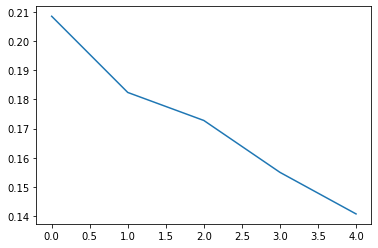

In [ ]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

## Example test set prep


In [7]:
test = pd.read_parquet('test_scaled_LatLonDateUnscaled.parquet')

print(test.columns)

print(test['date'].max())
print(test['date'].min())
print(len(test))
print(test.info())
test.head()

Index(['density', 'snowtemp', 'soiltemp', 'omega', 'Tbh', 'Tbv', 'cf', 'h',
       'voc', 'lat', 'lon', 'date'],
      dtype='object')
2019-12-31 00:00:00
2019-01-01 00:00:00
18329587
<class 'pandas.core.frame.DataFrame'>
Int64Index: 18329587 entries, 0 to 18329586
Data columns (total 12 columns):
 #   Column    Dtype         
---  ------    -----         
 0   density   float64       
 1   snowtemp  float64       
 2   soiltemp  float64       
 3   omega     float64       
 4   Tbh       float64       
 5   Tbv       float64       
 6   cf        float64       
 7   h         float64       
 8   voc       float64       
 9   lat       float64       
 10  lon       float64       
 11  date      datetime64[ns]
dtypes: datetime64[ns](1), float64(11)
memory usage: 1.8 GB
None


,density,snowtemp,soiltemp,omega,Tbh,Tbv,cf,h,voc,lat,lon,date
0,0.166630,0.908916,0.998302,0.779338,0.710750,0.708752,0.305672,0.124832,0.240164,62.684110,-160.44087,2019-01-01
1,0.176869,0.955726,0.995804,0.783470,0.715650,0.708749,0.311526,0.123756,0.228918,62.532246,-160.44087,2019-01-01
2,0.180525,0.959748,0.996218,0.790908,0.722035,0.714708,0.322348,0.123569,0.242246,62.381150,-160.44087,2019-01-01
3,0.183057,0.966050,0.996963,0.790081,0.721543,0.716810,0.302173,0.123513,0.240669,62.230810,-160.44087,2019-01-01
4,0.167732,0.926476,0.995828,0.789999,0.709735,0.705815,0.303099,0.123518,0.239886,62.684110,-160.34750,2019-01-01


In [ ]:
test1 = test[(test['lat'] == latlon['lat'].iloc[0]) & (test['lon'] == latlon['lon'].iloc[0])]
print(len(test1))
print(test1['date'].min())
print(test1['date'].max())
test1.head()
#Testing with the same lat/lon as train, this won't be matched in the larger set.

72
2020-01-01 00:00:00
2020-11-20 00:00:00


,density,snowtemp,soiltemp,omega,Tbh,Tbv,cf,h,voc,lat,lon,date
18329763,0.233223,0.537159,0.959042,0.779338,0.707065,0.712970,0.305672,0.124832,0.234089,62.68411,-160.44087,2020-01-01
18517417,0.215192,0.482522,0.962540,0.779338,0.709041,0.716228,0.305672,0.124832,0.234037,62.68411,-160.44087,2020-01-03
18577061,0.217689,0.420847,0.960800,0.779338,0.705201,0.705174,0.305672,0.124832,0.234016,62.68411,-160.44087,2020-01-04
18674566,0.219739,0.384268,0.954615,0.779338,0.700979,0.706267,0.305672,0.124832,0.233997,62.68411,-160.44087,2020-01-05
18772980,0.221373,0.323696,0.944928,0.779338,0.705278,0.709230,0.305672,0.124832,0.233980,62.68411,-160.44087,2020-01-06


In [ ]:
x_test1 = test1[['snowtemp', 'soiltemp', 'omega', 'Tbh', 'Tbv', 'cf', 'h', 'voc']]
x_test1 = np.array(x_test1)
y_test1 = test1[['density']]
y_test1 = np.array(y_test1)
y_test1 = y_test1.reshape(-1) #now is values in one array, not an array of arrays size 1. 

print(x_test1.shape)
print(y_test1.shape)

(72, 8)
(72,)


In [ ]:
X_test, y_test = gen_np(test1, n_input)

In [ ]:
test_generator = TimeseriesGenerator(x_test1, np.zeros(len(x_test1)), length=n_input, batch_size=b_size)
print(test_generator[0][0].shape) #We get the full 50 samples, could have had more since the actual lenth of test is 71.

(50, 3, 8)


In [ ]:
#y_hat = model.predict(test_generator)
y_hat = model.predict(X_test)

3/3 [==============================] - 0s 5ms/step


In [ ]:
#y_pred = Yscaler.inverse_transform(y_pred_scaled)
#results = pd.DataFrame({'y_test1':test1['density'].values[n_input:],'y_hat':y_hat.ravel()})
results = pd.DataFrame({'y_test1':y_test,'y_hat':y_hat.ravel()})
print(results)

     y_test1     y_hat
0   0.217689  0.235305
1   0.219739  0.233692
2   0.221373  0.232147
3   0.222658  0.231271
4   0.223785  0.230292
..       ...       ...
65  0.142432  0.245259
66  0.182735  0.240560
67  0.183829  0.239973
68  0.182399  0.239260
69  0.177009  0.241614

[70 rows x 2 columns]


In [ ]:
print('R2', skm.r2_score(results['y_test1'], results['y_hat']))
print('MAPE', skm.mean_absolute_percentage_error(results['y_test1'], results['y_hat']))
print('MAE', skm.mean_absolute_error(results['y_test1'], results['y_hat']))
print('RMSE', skm.mean_squared_error(results['y_test1'], results['y_hat'], squared = False))
print( 'MSE', skm.mean_squared_error(results['y_test1'], results['y_hat']))

R2 -0.018116347457838078
MAPE 0.13819738284814045
MAE 0.033359309261546344
RMSE 0.043977989876406685
MSE 0.001934063593569329


Old:
R2 -17.570187310639216
MAPE 0.7333341272085523
MAE 0.1834174423880057
RMSE 0.1885665896580615
MSE 0.035557358735271744

## Data Prep

In [25]:
#Peramaeters: 
n_input = 60 #how many samples/rows/timesteps to look in the past in order to forecast the next sample
n_features = 7 # how many predictors/Xs/features we have to predict y

In [35]:
# Import data:
train = pd.read_parquet('train_scaled_LatLonDateUnscaled.parquet')

print(train.columns)

print(train['date'].max())
print(train['date'].min())
print(len(train))
print(train.info())
print(train.shape)
train.head()

Index(['density', 'snowtemp', 'soiltemp', 'omega', 'Tbh', 'Tbv', 'cf', 'h',
       'voc', 'lat', 'lon', 'date'],
      dtype='object')
2019-12-31 00:00:00
2019-01-01 00:00:00
18329587
<class 'pandas.core.frame.DataFrame'>
Int64Index: 18329587 entries, 0 to 18329586
Data columns (total 12 columns):
 #   Column    Dtype         
---  ------    -----         
 0   density   float64       
 1   snowtemp  float64       
 2   soiltemp  float64       
 3   omega     float64       
 4   Tbh       float64       
 5   Tbv       float64       
 6   cf        float64       
 7   h         float64       
 8   voc       float64       
 9   lat       float64       
 10  lon       float64       
 11  date      datetime64[ns]
dtypes: datetime64[ns](1), float64(11)
memory usage: 1.8 GB
None
(18329587, 12)


,density,snowtemp,soiltemp,omega,Tbh,Tbv,cf,h,voc,lat,lon,date
0,0.166630,0.908916,0.998302,0.779338,0.710750,0.708752,0.305672,0.124832,0.240164,62.684110,-160.44087,2019-01-01
1,0.176869,0.955726,0.995804,0.783470,0.715650,0.708749,0.311526,0.123756,0.228918,62.532246,-160.44087,2019-01-01
2,0.180525,0.959748,0.996218,0.790908,0.722035,0.714708,0.322348,0.123569,0.242246,62.381150,-160.44087,2019-01-01
3,0.183057,0.966050,0.996963,0.790081,0.721543,0.716810,0.302173,0.123513,0.240669,62.230810,-160.44087,2019-01-01
4,0.167732,0.926476,0.995828,0.789999,0.709735,0.705815,0.303099,0.123518,0.239886,62.684110,-160.34750,2019-01-01


In [108]:
latlon = latlon_setup(train, n_input)

123873


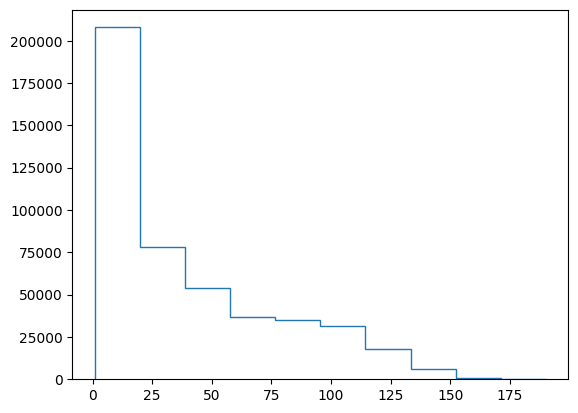

In [17]:
pixel_counts = train.groupby(['lat', 'lon']).size()
counts, bins = np.histogram(pixel_counts[0])
plt.stairs(counts, bins)

In [40]:
X = np.empty([0, n_input, n_features])
y = np.empty([0, 2])

print(X, y)

counter = 0
savept = 0
savept = 0
print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))

[] []
2022-12-20 12:17:25


In [120]:
n_input = 80
n_features = 7

path = 'LSTMData80Sparse/XY_arrays_LSTM_80Sparse_'

latlon = latlon_setup(train, n_input)
X = np.empty([0, n_input, n_features])
y = np.empty([0, 2])
counter = 85000
savept = 85

print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
data_prep(train, latlon, path, n_input, n_features, X, y, counter, savept)

Length of df of unique latlon paris that meet cutoff:  85603
2022-12-20 18:05:19
Save last: 


TypeError: unsupported operand type(s) for -: 'str' and 'str'

In [41]:
# n_input = 60
# n_features = 7
#
# path = 'LSTMData60Sparse/XY_arrays_LSTM_60Sparse_'
#
# latlon = latlon_setup(train, n_input)
# X = np.empty([0, n_input, n_features])
# y = np.empty([0, 2])
# counter = 0
# savept = 0
#
# print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
# data_prep(train, latlon, path, n_input, n_features, X, y, counter, savept)

Counter:  10000 , Shape X:  (40763, 60, 7) 2022-12-20 12:25:30
Wipeout:  0
Counter:  20000 , Shape X:  (40738, 60, 7) 2022-12-20 12:33:48
Wipeout:  1
Counter:  30000 , Shape X:  (40793, 60, 7) 2022-12-20 12:42:34
Wipeout:  2
Counter:  40000 , Shape X:  (40669, 60, 7) 2022-12-20 12:51:36
Wipeout:  3
Counter:  50000 , Shape X:  (40449, 60, 7) 2022-12-20 13:00:42
Wipeout:  4
Counter:  60000 , Shape X:  (40742, 60, 7) 2022-12-20 13:09:49
Wipeout:  5
Counter:  70000 , Shape X:  (40791, 60, 7) 2022-12-20 13:18:56
Wipeout:  6
Counter:  80000 , Shape X:  (40857, 60, 7) 2022-12-20 13:27:36
Wipeout:  7
Counter:  90000 , Shape X:  (40889, 60, 7) 2022-12-20 13:36:13
Wipeout:  8
Counter:  100000 , Shape X:  (40264, 60, 7) 2022-12-20 13:45:03
Wipeout:  9
Counter:  110000 , Shape X:  (40733, 60, 7) 2022-12-20 13:54:12
Wipeout:  10
Counter:  120000 , Shape X:  (41158, 60, 7) 2022-12-20 14:02:55
Wipeout:  11


In [42]:
print(counter)

123873


In [123]:
X_train = np.empty([0, n_input, n_features])
y_train = np.empty([0,2])
X_val = np.empty([0, n_input, n_features])
y_val = np.empty([0,2])

In [124]:
path = 'LSTMData80Sparse'
filecount = len(os.listdir(path))
for filename in os.listdir(path):
    filecount = filecount-1
    f = os.path.join(path, filename)
    if filecount > 16:
        print(f)
        with open(f, 'rb') as f: #Saves two arrays in same file, arrays can be opened separately or together.
            X_load = np.load(f)
            y_load = np.load(f)
        X_train = np.vstack([X_train, X_load]) #Append your arrays
        y_train = np.concatenate([y_train, y_load])
        print("Train: ", f)
    else:
        with open(f, 'rb') as f: #Saves two arrays in same file, arrays can be opened separately or together.
            X_load = np.load(f)
            y_load = np.load(f)
        X_val = np.vstack([X_val, X_load]) #Append your arrays
        y_val = np.concatenate([y_val, y_load])
        print("Val: ", f)

LSTMData80Sparse\XY_arrays_80Sparse_LSTM_Train_0.npy
Train:  <_io.BufferedReader name='LSTMData80Sparse\\XY_arrays_80Sparse_LSTM_Train_0.npy'>
LSTMData80Sparse\XY_arrays_80Sparse_LSTM_Train_1.npy
Train:  <_io.BufferedReader name='LSTMData80Sparse\\XY_arrays_80Sparse_LSTM_Train_1.npy'>
LSTMData80Sparse\XY_arrays_80Sparse_LSTM_Train_10.npy
Train:  <_io.BufferedReader name='LSTMData80Sparse\\XY_arrays_80Sparse_LSTM_Train_10.npy'>
LSTMData80Sparse\XY_arrays_80Sparse_LSTM_Train_11.npy
Train:  <_io.BufferedReader name='LSTMData80Sparse\\XY_arrays_80Sparse_LSTM_Train_11.npy'>
LSTMData80Sparse\XY_arrays_80Sparse_LSTM_Train_12.npy
Train:  <_io.BufferedReader name='LSTMData80Sparse\\XY_arrays_80Sparse_LSTM_Train_12.npy'>
LSTMData80Sparse\XY_arrays_80Sparse_LSTM_Train_13.npy
Train:  <_io.BufferedReader name='LSTMData80Sparse\\XY_arrays_80Sparse_LSTM_Train_13.npy'>
LSTMData80Sparse\XY_arrays_80Sparse_LSTM_Train_14.npy
Train:  <_io.BufferedReader name='LSTMData80Sparse\\XY_arrays_80Sparse_LSTM_Trai

In [125]:
print(X_train.shape) #(4352938, 60, 7)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_val.shape[0] / (X_val.shape[0] + X_train.shape[0])) #60: 0.192, 80: 0.194
with open((path + '/XY_80Sparse_Full_XYTrainVal.npy'), 'wb') as f:
      np.save(f, X_train)
      np.save(f, y_train)
      np.save(f, X_val)
      np.save(f, y_val)

(220426, 80, 7)
(220426, 2)
(53072, 80, 7)
(53072, 2)
0.19404895099781352


## Training - 60 Sparse

In [53]:
#https://towardsdatascience.com/choosing-the-right-hyperparameters-for-a-simple-lstm-using-keras-f8e9ed76f046
hidden_nodes_ex = int(2/3 * (n_input * n_features * y_train.shape[1]))
hidden_nodes_ex2 = int(X_train.shape[0] / 10 * (n_input * n_features * y_train.shape[1]))
print(f"One approximation of the number of hidden nodes is {hidden_nodes_ex}.")
print(f"Another approximation of the number of hidden nodes is {hidden_nodes_ex2}.")

hidden_nodes = 60
print(f"We will be using {hidden_nodes}, as this is reasonable to train and the same number we used for the DNN.")

One approximation of the number of hidden nodes is 560.
Another approximation of the number of hidden nodes is 34246212.
We will be using 60, as this is reasonable to train and the same number we used for the DNN.


In [54]:
print(X_train.shape) #(4352938, 60, 7), (3508883, 60, 7), (407693, 60, 7)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(407693, 60, 7)
(407693, 2)
(97028, 60, 7)
(97028, 2)


In [56]:
model = model_lstm()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 60, 60)            16320     
                                                                 
 dropout_2 (Dropout)         (None, 60, 60)            0         
                                                                 
 lstm_3 (LSTM)               (None, 60)                29040     
                                                                 
 dropout_3 (Dropout)         (None, 60)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 122       
                                                                 
Total params: 45,482
Trainable params: 45,482
Non-trainable params: 0
_________________________________________________________________


In [64]:
batch_size = 500

callbacks_list = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=3
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath="ModelCheckpoints60/model.{epoch:02d}-{val_loss:.2f}.h5",
        monitor="val_loss",
        mode="min",
        save_best_only=True,
    )
]

In [58]:
print("Time: ", time.strftime("%H:%M:%S", time.localtime()))

history_retrieval = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val),
                               batch_size = batch_size, callbacks=callbacks_list, verbose=1)

print("Time: ", time.strftime("%H:%M:%S", time.localtime()))

Time:  14:14:29
Epoch 1/20
816/816 [==============================] - 461s 563ms/step - loss: 0.0250 - val_loss: 0.0195
Epoch 2/20
816/816 [==============================] - 407s 499ms/step - loss: 0.0190 - val_loss: 0.0179
Epoch 3/20
816/816 [==============================] - 369s 452ms/step - loss: 0.0168 - val_loss: 0.0151
Epoch 4/20
816/816 [==============================] - 351s 430ms/step - loss: 0.0159 - val_loss: 0.0149
Epoch 5/20
816/816 [==============================] - 327s 401ms/step - loss: 0.0150 - val_loss: 0.0142
Epoch 6/20
816/816 [==============================] - 346s 424ms/step - loss: 0.0144 - val_loss: 0.0133
Epoch 7/20
816/816 [==============================] - 347s 425ms/step - loss: 0.0140 - val_loss: 0.0134
Epoch 8/20
816/816 [==============================] - 355s 435ms/step - loss: 0.0138 - val_loss: 0.0139
Epoch 9/20
816/816 [==============================] - 337s 412ms/step - loss: 0.0136 - val_loss: 0.0150
Time:  15:09:29


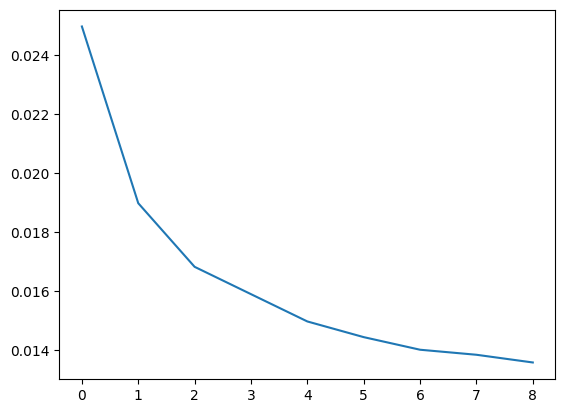

In [59]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [63]:
model.save('ModelCheckpoints60/model60sparse_final.h5')

In [65]:
model.evaluate(X_train, y_train, batch_size=batch_size, callbacks=callbacks_list, verbose=1)

816/816 [==============================] - 71s 88ms/step - loss: 0.0152


0.015179895795881748

In [66]:
model.evaluate(X_val, y_val, batch_size=batch_size, callbacks=callbacks_list, verbose=1)

195/195 [==============================] - 16s 80ms/step - loss: 0.0150


0.015012651681900024

In [60]:
#Compile test data:
X_test = np.empty([0, n_input, n_features])
y_test = np.empty([0,2])
path = 'LSTM_Data_60Sparse_Test'
filecount = len(os.listdir(path))
for filename in os.listdir(path):
    filecount = filecount-1
    p = os.path.join(path, filename)
    with open(p, 'rb') as f: #Saves two arrays in same file, arrays can be opened separately or together.
        X_load = np.load(f)
        y_load = np.load(f)
    X_test = np.vstack([X_test, X_load]) #Append your arrays
    y_test = np.concatenate([y_test, y_load])
    print("Test: ", f, X_test.shape)

Test:  <_io.BufferedReader name='LSTM_Data_60Sparse_Test\\XY_arrays_60Sparse_LSTM_Test_0.npy'> (3491, 60, 7)
Test:  <_io.BufferedReader name='LSTM_Data_60Sparse_Test\\XY_arrays_60Sparse_LSTM_Test_1.npy'> (6941, 60, 7)
Test:  <_io.BufferedReader name='LSTM_Data_60Sparse_Test\\XY_arrays_60Sparse_LSTM_Test_10.npy'> (10496, 60, 7)
Test:  <_io.BufferedReader name='LSTM_Data_60Sparse_Test\\XY_arrays_60Sparse_LSTM_Test_11.npy'> (13821, 60, 7)
Test:  <_io.BufferedReader name='LSTM_Data_60Sparse_Test\\XY_arrays_60Sparse_LSTM_Test_12.npy'> (17316, 60, 7)
Test:  <_io.BufferedReader name='LSTM_Data_60Sparse_Test\\XY_arrays_60Sparse_LSTM_Test_13.npy'> (20822, 60, 7)
Test:  <_io.BufferedReader name='LSTM_Data_60Sparse_Test\\XY_arrays_60Sparse_LSTM_Test_14.npy'> (24251, 60, 7)
Test:  <_io.BufferedReader name='LSTM_Data_60Sparse_Test\\XY_arrays_60Sparse_LSTM_Test_15.npy'> (27704, 60, 7)
Test:  <_io.BufferedReader name='LSTM_Data_60Sparse_Test\\XY_arrays_60Sparse_LSTM_Test_16.npy'> (31017, 60, 7)
Test:

In [67]:
print(X_test.shape)
print(y_test.shape)

(302794, 60, 7)
(302794, 2)


In [68]:
y_pred = model.predict(X_test, batch_size=batch_size, callbacks=callbacks_list, verbose=1)

606/606 [==============================] - 45s 73ms/step


In [77]:
print(y_pred.shape)
print(y_pred[0:5,])
print(y_test[0:5]) #is Density then VOD:

(302794, 2)
[[0.23307545 0.4318809 ]
 [0.2775002  0.4064901 ]
 [0.15507063 0.21285887]
 [0.32374465 0.4366291 ]
 [0.41131687 0.22793666]]
[[0.28613892 0.22324183]
 [0.30487439 0.22310174]
 [0.14736087 0.22358704]
 [0.30502508 0.22355998]
 [0.3660039  0.22322477]]


In [80]:
#Snow density:
mae = skm.mean_absolute_error(y_test[:,0], y_pred[:,0])
mse = skm.mean_squared_error(y_test[:,0], y_pred[:,0])
rmse = skm.mean_squared_error(y_test[:,0], y_pred[:,0], squared = False)
r2 = skm.r2_score(y_test[:,0], y_pred[:,0])
print("Snow Density Performance: ")
print("MAE: ", mae)
print("MSE: ", mse)
print("RMSE: ", rmse)
print("R2: ", r2)


Snow Density Performance: 
MAE:  0.06776746113589963
MSE:  0.009728605803439918
RMSE:  0.09863369507141015
R2:  0.5597049632701769


In [81]:
#Snow density:
mae2 = skm.mean_absolute_error(y_test[:,1], y_pred[:,1])
mse2 = skm.mean_squared_error(y_test[:,1], y_pred[:,1])
rmse2 = skm.mean_squared_error(y_test[:,1], y_pred[:,1], squared = False)
r22 = skm.r2_score(y_test[:,1], y_pred[:,1])
print("VOD Performance: ")
print("MAE: ", mae2)
print("MSE: ", mse2)
print("RMSE: ", rmse2)
print("R2: ", r22)

VOD Performance: 
MAE:  0.08803249813027872
MSE:  0.025105152039051885
RMSE:  0.1584460540343365
R2:  0.30884914547654385


## Unscaling results

In [100]:
#DataPrep: Scaling
data = pd.read_parquet('processed_data_with_datetime.parquet')
scaler = MinMaxScaler()
data_scaled = data[['density', 'voc']] #We want lat, lon and date unscaled, as these will be used for sorting, not training.
data_scaled = scaler.fit_transform(data_scaled)
data_scaled

array([[0.16662979, 0.24016423],
       [0.17686891, 0.22891788],
       [0.18052546, 0.2422458 ],
       ...,
       [0.25501974, 0.08590267],
       [0.2623392 , 0.0891739 ],
       [0.26668053, 0.0891739 ]])

In [101]:
y_test_unscaled = scaler.inverse_transform(y_test)
y_test_unscaled

array([[2.00148606e+02, 3.34834448e-01],
       [2.06706021e+02, 3.34624320e-01],
       [1.51576290e+02, 3.35352222e-01],
       ...,
       [1.51203990e+02, 2.34826122e-01],
       [2.39833129e+02, 2.35251186e-01],
       [1.49249027e+02, 3.04576535e-02]])

In [102]:
y_pred_unscaled = scaler.inverse_transform(y_pred)
y_pred_unscaled

array([[1.8157640e+02, 6.4776659e-01],
       [1.9712506e+02, 6.0968357e-01],
       [1.5427470e+02, 3.1926131e-01],
       ...,
       [1.5607784e+02, 2.7125862e-01],
       [2.2930032e+02, 1.9054066e-01],
       [1.8682938e+02, 1.2644555e-01]], dtype=float32)

In [103]:
#Snow density:
mae = skm.mean_absolute_error(y_test_unscaled[:, 0], y_pred_unscaled[:, 0])
mse = skm.mean_squared_error(y_test_unscaled[:, 0], y_pred_unscaled[:, 0])
rmse = skm.mean_squared_error(y_test_unscaled[:, 0], y_pred_unscaled[:, 0], squared=False)
r2 = skm.r2_score(y_test_unscaled[:, 0], y_pred_unscaled[:, 0])
print("Snow Density Performance: ")
print("MAE: ", mae)
print("MSE: ", mse)
print("RMSE: ", rmse)
print("R2: ", r2)

#VOD:
mae2 = skm.mean_absolute_error(y_test_unscaled[:, 1], y_pred_unscaled[:, 1])
mse2 = skm.mean_squared_error(y_test_unscaled[:, 1], y_pred_unscaled[:, 1])
rmse2 = skm.mean_squared_error(y_test_unscaled[:, 1], y_pred_unscaled[:, 1], squared=False)
r22 = skm.r2_score(y_test_unscaled[:, 1], y_pred_unscaled[:, 1])
print("VOD Performance: ")
print("MAE: ", mae2)
print("MSE: ", mse2)
print("RMSE: ", rmse2)
print("R2: ", r22)

Snow Density Performance: 
MAE:  23.718610978952434
MSE:  1191.754187683344
RMSE:  34.521792938422884
R2:  0.5597049718555008
VOD Performance: 
MAE:  0.1320375867482831
MSE:  0.05647704427997352
RMSE:  0.23764899385432608
R2:  0.30884914539383856


## Training 80 Sparse

In [126]:
print(X_train.shape)  #(4352938, 60, 7), (3508883, 60, 7), (407693, 60, 7), 80: (220426, 80, 7)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

batch_size = 500

callbacks_list = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=3
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath="ModelCheckpoints80/model.{epoch:02d}-{val_loss:.2f}.h5",
        monitor="val_loss",
        mode="min",
        save_best_only=True,
    )
]

(220426, 80, 7)
(220426, 2)
(53072, 80, 7)
(53072, 2)


In [127]:
model2 = model_lstm()
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 80, 60)            16320     
                                                                 
 dropout_4 (Dropout)         (None, 80, 60)            0         
                                                                 
 lstm_5 (LSTM)               (None, 60)                29040     
                                                                 
 dropout_5 (Dropout)         (None, 60)                0         
                                                                 
 dense_2 (Dense)             (None, 2)                 122       
                                                                 
Total params: 45,482
Trainable params: 45,482
Non-trainable params: 0
_________________________________________________________________


In [128]:
print("Time: ", time.strftime("%H:%M:%S", time.localtime()))

history_retrieval2 = model2.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val),
                              batch_size=batch_size, callbacks=callbacks_list, verbose=1)

print("Time: ", time.strftime("%H:%M:%S", time.localtime()))

Time:  18:17:37
Epoch 1/20
441/441 [==============================] - 386s 870ms/step - loss: 0.0217 - val_loss: 0.0199
Epoch 2/20
441/441 [==============================] - 380s 863ms/step - loss: 0.0173 - val_loss: 0.0149
Epoch 3/20
441/441 [==============================] - 381s 864ms/step - loss: 0.0158 - val_loss: 0.0143
Epoch 4/20
441/441 [==============================] - 363s 824ms/step - loss: 0.0147 - val_loss: 0.0137
Epoch 5/20
441/441 [==============================] - 376s 854ms/step - loss: 0.0140 - val_loss: 0.0126
Epoch 6/20
441/441 [==============================] - 376s 852ms/step - loss: 0.0138 - val_loss: 0.0121
Epoch 7/20
441/441 [==============================] - 385s 873ms/step - loss: 0.0132 - val_loss: 0.0140
Epoch 8/20
441/441 [==============================] - 390s 883ms/step - loss: 0.0128 - val_loss: 0.0136
Epoch 9/20
441/441 [==============================] - 379s 859ms/step - loss: 0.0127 - val_loss: 0.0115
Epoch 10/20
441/441 [===========================

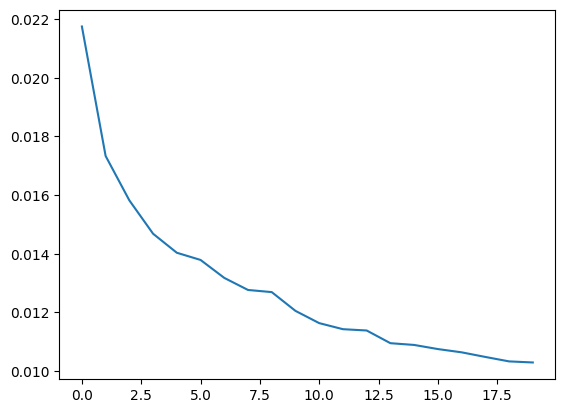

In [129]:
loss_per_epoch = model2.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

In [130]:
model2.save('ModelCheckpoints80/model80sparse_final.h5')

In [131]:
model2.evaluate(X_train, y_train, batch_size=batch_size, callbacks=callbacks_list, verbose=1)

441/441 [==============================] - 83s 188ms/step - loss: 0.0098


0.00978927593678236

In [132]:
model2.evaluate(X_val, y_val, batch_size=batch_size, callbacks=callbacks_list, verbose=1)

107/107 [==============================] - 21s 194ms/step - loss: 0.0094


0.009396200999617577

In [134]:
X_test = np.empty([0, n_input, n_features])
y_test = np.empty([0,2])
path = 'LSTM_Data_80Sparse_Test'
X_test, y_test = assemble_test(X_test, y_test, path)

Test:  <_io.BufferedReader name='LSTM_Data_80Sparse_Test\\XY_arrays_80Sparse_LSTM_Test_0.npy'> (2850, 80, 7)
Test:  <_io.BufferedReader name='LSTM_Data_80Sparse_Test\\XY_arrays_80Sparse_LSTM_Test_1.npy'> (5722, 80, 7)
Test:  <_io.BufferedReader name='LSTM_Data_80Sparse_Test\\XY_arrays_80Sparse_LSTM_Test_10.npy'> (8552, 80, 7)
Test:  <_io.BufferedReader name='LSTM_Data_80Sparse_Test\\XY_arrays_80Sparse_LSTM_Test_11.npy'> (11412, 80, 7)
Test:  <_io.BufferedReader name='LSTM_Data_80Sparse_Test\\XY_arrays_80Sparse_LSTM_Test_12.npy'> (14182, 80, 7)
Test:  <_io.BufferedReader name='LSTM_Data_80Sparse_Test\\XY_arrays_80Sparse_LSTM_Test_13.npy'> (17087, 80, 7)
Test:  <_io.BufferedReader name='LSTM_Data_80Sparse_Test\\XY_arrays_80Sparse_LSTM_Test_14.npy'> (19873, 80, 7)
Test:  <_io.BufferedReader name='LSTM_Data_80Sparse_Test\\XY_arrays_80Sparse_LSTM_Test_15.npy'> (22815, 80, 7)
Test:  <_io.BufferedReader name='LSTM_Data_80Sparse_Test\\XY_arrays_80Sparse_LSTM_Test_16.npy'> (25684, 80, 7)
Test: 

In [135]:
print(X_test.shape)
print(y_test.shape)

(142225, 80, 7)
(142225, 2)


In [137]:
y_pred = model2.predict(X_test, batch_size=batch_size, callbacks=callbacks_list, verbose=1)

285/285 [==============================] - 56s 193ms/step


In [139]:
y_test_unscaled = scaler.inverse_transform(y_test)
y_test_unscaled

y_pred_unscaled = scaler.inverse_transform(y_pred)
y_pred_unscaled

array([[1.8332982e+02, 1.6236126e-01],
       [2.4451628e+02, 2.1423501e-01],
       [2.0108072e+02, 1.6824916e-01],
       ...,
       [1.5654552e+02, 4.5745993e-01],
       [1.9972498e+02, 5.1051116e-01],
       [2.2410820e+02, 4.8677689e-01]], dtype=float32)

In [138]:
print("Metrics for 80 sparse, scaled:")
get_metrics(y_test, y_pred)

Metrics for 80 sparse, scaled:
Snow Density Performance: 
MAE:  0.06368325221758922
MSE:  0.009844589015032493
RMSE:  0.09921990231315739
R2:  0.6366401227278846
VOD Performance: 
MAE:  0.0704987100757687
MSE:  0.016163048150139425
RMSE:  0.12713397716637131
R2:  0.31666451781676475


(0.06368325221758922,
 0.009844589015032493,
 0.09921990231315739,
 0.6366401227278846,
 0.0704987100757687,
 0.016163048150139425,
 0.12713397716637131,
 0.31666451781676475)

In [140]:
print("Metrics for 80 sparse, unscaled:")
get_metrics(y_test_unscaled, y_pred_unscaled)

Metrics for 80 sparse, unscaled:
Snow Density Performance: 
MAE:  22.289138023393658
MSE:  1205.9621534868168
RMSE:  34.726965797299606
R2:  0.636640122985397
VOD Performance: 
MAE:  0.10573912753212986
MSE:  0.036360711321544385
RMSE:  0.19068484816981235
R2:  0.3166645178093449


(22.289138023393658,
 1205.9621534868168,
 34.726965797299606,
 0.636640122985397,
 0.10573912753212986,
 0.036360711321544385,
 0.19068484816981235,
 0.3166645178093449)

## Data Prep Sparse 30 Train

In [153]:
n_input = 30
n_features = 7
latlon = latlon_setup(train, n_input)
X = np.empty([0, n_input, n_features])
y = np.empty([0,2])
path = 'LSTM_Data_30Sparse_Train/XY_arrays_30Sparse_LSTM_Train_'
counter = 20000
savept = 2

data_prep(train, latlon, path, n_input, n_features, X, y, counter, savept)

Length of df of unique latlon paris that meet cutoff:  215553
Counter:  30000 , Shape X:  (48892, 30, 7) 2022-12-20 21:12:33
Wipeout:  2
Counter:  40000 , Shape X:  (49102, 30, 7) 2022-12-20 21:20:47
Wipeout:  3
Counter:  50000 , Shape X:  (48974, 30, 7) 2022-12-20 21:29:03
Wipeout:  4
Counter:  60000 , Shape X:  (49356, 30, 7) 2022-12-20 21:37:01
Wipeout:  5
Counter:  70000 , Shape X:  (49228, 30, 7) 2022-12-20 21:45:10
Wipeout:  6
Counter:  80000 , Shape X:  (48560, 30, 7) 2022-12-20 21:53:17
Wipeout:  7
Counter:  90000 , Shape X:  (48654, 30, 7) 2022-12-20 22:01:30
Wipeout:  8
Counter:  100000 , Shape X:  (48670, 30, 7) 2022-12-20 22:09:40
Wipeout:  9
Counter:  110000 , Shape X:  (49140, 30, 7) 2022-12-20 22:17:49
Wipeout:  10
Counter:  120000 , Shape X:  (49625, 30, 7) 2022-12-20 22:26:08
Wipeout:  11
Counter:  130000 , Shape X:  (48327, 30, 7) 2022-12-20 22:34:34
Wipeout:  12
Counter:  140000 , Shape X:  (48650, 30, 7) 2022-12-20 22:43:02
Wipeout:  13
Counter:  150000 , Shape X:  

In [155]:
X_train = np.empty([0, n_input, n_features])
y_train = np.empty([0,2])
X_val = np.empty([0, n_input, n_features])
y_val = np.empty([0,2])
path = 'LSTM_Data_30Sparse_Train'
switch = int(len(os.listdir(path))*.2)
X_train, y_train, X_val, y_val = assemble_train(X_train, y_train, X_val, y_val, path, switch)

LSTM_Data_30Sparse_Train\XY_arrays_30Sparse_LSTM_Train0.npy
Train:  <_io.BufferedReader name='LSTM_Data_30Sparse_Train\\XY_arrays_30Sparse_LSTM_Train0.npy'>
LSTM_Data_30Sparse_Train\XY_arrays_30Sparse_LSTM_Train1.npy
Train:  <_io.BufferedReader name='LSTM_Data_30Sparse_Train\\XY_arrays_30Sparse_LSTM_Train1.npy'>
LSTM_Data_30Sparse_Train\XY_arrays_30Sparse_LSTM_Train_10.npy
Train:  <_io.BufferedReader name='LSTM_Data_30Sparse_Train\\XY_arrays_30Sparse_LSTM_Train_10.npy'>
LSTM_Data_30Sparse_Train\XY_arrays_30Sparse_LSTM_Train_11.npy
Train:  <_io.BufferedReader name='LSTM_Data_30Sparse_Train\\XY_arrays_30Sparse_LSTM_Train_11.npy'>
LSTM_Data_30Sparse_Train\XY_arrays_30Sparse_LSTM_Train_12.npy
Train:  <_io.BufferedReader name='LSTM_Data_30Sparse_Train\\XY_arrays_30Sparse_LSTM_Train_12.npy'>
LSTM_Data_30Sparse_Train\XY_arrays_30Sparse_LSTM_Train_13.npy
Train:  <_io.BufferedReader name='LSTM_Data_30Sparse_Train\\XY_arrays_30Sparse_LSTM_Train_13.npy'>
LSTM_Data_30Sparse_Train\XY_arrays_30Spars

In [156]:
print(X_train.shape) #(4352938, 60, 7), 30:(782744, 30, 7)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_val.shape[0] / (X_val.shape[0] + X_train.shape[0])) #60: 0.192, 80: 0.194
with open((path + '/XY_30Sparse_Full_XYTrainVal.npy'), 'wb') as f:
      np.save(f, X_train)
      np.save(f, y_train)
      np.save(f, X_val)
      np.save(f, y_val)

(782744, 30, 7)
(782744, 2)
(271881, 30, 7)
(271881, 2)
0.2577987436292521


In [157]:
model = model_lstm()
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 30, 60)            16320     
                                                                 
 dropout_6 (Dropout)         (None, 30, 60)            0         
                                                                 
 lstm_7 (LSTM)               (None, 60)                29040     
                                                                 
 dropout_7 (Dropout)         (None, 60)                0         
                                                                 
 dense_3 (Dense)             (None, 2)                 122       
                                                                 
Total params: 45,482
Trainable params: 45,482
Non-trainable params: 0
_________________________________________________________________


In [159]:
batch_size = 500

callbacks_list = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=3
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath="ModelCheckpoints30/model.{epoch:02d}-{val_loss:.2f}.h5",
        monitor="val_loss",
        mode="min",
        save_best_only=True,
    )
]

In [160]:
print("Time: ", time.strftime("%H:%M:%S", time.localtime()))

history_retrieval = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val),
                              batch_size=batch_size, callbacks=callbacks_list, verbose=1)

print("Time: ", time.strftime("%H:%M:%S", time.localtime()))



Time:  23:57:15
Epoch 1/20
1566/1566 [==============================] - 372s 236ms/step - loss: 0.0243 - val_loss: 0.0197
Epoch 2/20
1566/1566 [==============================] - 345s 220ms/step - loss: 0.0195 - val_loss: 0.0180
Epoch 3/20
1566/1566 [==============================] - 273s 175ms/step - loss: 0.0183 - val_loss: 0.0182
Epoch 4/20
1566/1566 [==============================] - 284s 181ms/step - loss: 0.0175 - val_loss: 0.0168
Epoch 5/20
1566/1566 [==============================] - 301s 192ms/step - loss: 0.0170 - val_loss: 0.0171
Epoch 6/20
1566/1566 [==============================] - 359s 229ms/step - loss: 0.0165 - val_loss: 0.0159
Epoch 7/20
1566/1566 [==============================] - 428s 273ms/step - loss: 0.0162 - val_loss: 0.0162
Epoch 8/20
1566/1566 [==============================] - 440s 281ms/step - loss: 0.0158 - val_loss: 0.0157
Epoch 9/20
1566/1566 [==============================] - 444s 284ms/step - loss: 0.0156 - val_loss: 0.0144
Epoch 10/20
1566/1566 [=======

In [161]:
model.save('ModelCheckpoints30/model30sparse_final.h5')

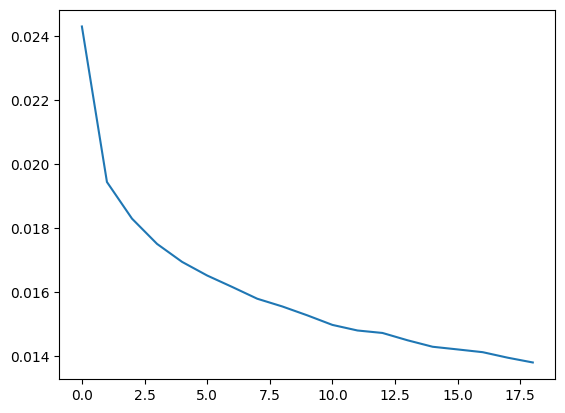

In [162]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

In [163]:
model.evaluate(X_train, y_train, batch_size=batch_size, callbacks=callbacks_list, verbose=1)

1566/1566 [==============================] - 134s 85ms/step - loss: 0.0135


0.013468669727444649

In [164]:
model2.evaluate(X_val, y_val, batch_size=batch_size, callbacks=callbacks_list, verbose=1)

544/544 [==============================] - 49s 89ms/step - loss: 0.0301


0.030079761520028114

In [165]:
X_test = np.empty([0, n_input, n_features])
y_test = np.empty([0, 2])
path = 'LSTM_Data_30Sparse_Test'
X_test, y_test = assemble_test(X_test, y_test, path)

print(X_test.shape)
print(y_test.shape)

Test:  <_io.BufferedReader name='LSTM_Data_30Sparse_Test\\XY_arrays_30Sparse_LSTM_Test_0.npy'> (48892, 30, 7)
Test:  <_io.BufferedReader name='LSTM_Data_30Sparse_Test\\XY_arrays_30Sparse_LSTM_Test_1.npy'> (97994, 30, 7)
Test:  <_io.BufferedReader name='LSTM_Data_30Sparse_Test\\XY_arrays_30Sparse_LSTM_Test_10.npy'> (146321, 30, 7)
Test:  <_io.BufferedReader name='LSTM_Data_30Sparse_Test\\XY_arrays_30Sparse_LSTM_Test_11.npy'> (194971, 30, 7)
Test:  <_io.BufferedReader name='LSTM_Data_30Sparse_Test\\XY_arrays_30Sparse_LSTM_Test_12.npy'> (243724, 30, 7)
Test:  <_io.BufferedReader name='LSTM_Data_30Sparse_Test\\XY_arrays_30Sparse_LSTM_Test_13.npy'> (292995, 30, 7)
Test:  <_io.BufferedReader name='LSTM_Data_30Sparse_Test\\XY_arrays_30Sparse_LSTM_Test_14.npy'> (341814, 30, 7)
Test:  <_io.BufferedReader name='LSTM_Data_30Sparse_Test\\XY_arrays_30Sparse_LSTM_Test_15.npy'> (390679, 30, 7)
Test:  <_io.BufferedReader name='LSTM_Data_30Sparse_Test\\XY_arrays_30Sparse_LSTM_Test_16.npy'> (439404, 30,

In [166]:
y_pred = model.predict(X_test, batch_size=batch_size, callbacks=callbacks_list, verbose=1)

2109/2109 [==============================] - 219s 103ms/step


In [167]:
y_test_unscaled = scaler.inverse_transform(y_test)
y_test_unscaled

y_pred_unscaled = scaler.inverse_transform(y_pred)
y_pred_unscaled

array([[2.9794083e+02, 2.6936841e-01],
       [2.5505013e+02, 1.9362469e-01],
       [2.3156006e+02, 2.0710987e-01],
       ...,
       [1.6291206e+02, 3.9036390e-01],
       [1.7536044e+02, 3.4844720e-01],
       [1.7036363e+02, 3.3901000e-01]], dtype=float32)

In [168]:
print("Metrics for 80 sparse, scaled:")
get_metrics(y_test, y_pred)
print("Metrics for 80 sparse, unscaled:")
get_metrics(y_test_unscaled, y_pred_unscaled)

Metrics for 80 sparse, scaled:
Snow Density Performance: 
MAE:  0.03625762413142435
MSE:  0.0035934464750510043
RMSE:  0.05994536241487747
R2:  0.7628973558285523
VOD Performance: 
MAE:  0.08452074440335217
MSE:  0.023705100653086925
RMSE:  0.15396460844326182
R2:  0.6513472458784648
Metrics for 80 sparse, unscaled:
Snow Density Performance: 
MAE:  12.690168333240559
MSE:  440.19718218177934
RMSE:  20.980876582778407
R2:  0.7628973617599096
VOD Performance: 
MAE:  0.1267704013672531
MSE:  0.05332746110486599
RMSE:  0.23092739357829767
R2:  0.6513472459282392


(12.690168333240559,
 440.19718218177934,
 20.980876582778407,
 0.7628973617599096,
 0.1267704013672531,
 0.05332746110486599,
 0.23092739357829767,
 0.6513472459282392)

C:\Users\calvino\Documents\Courses\GradSchoolStuff\CSCI 8523 - AI for Earth, Kumar\Group Project\venv\lib\site-packages\mpl_scatter_density\generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
C:\Users\calvino\Documents\Courses\GradSchoolStuff\CSCI 8523 - AI for Earth, Kumar\Group Project\venv\lib\site-packages\mpl_scatter_density\generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


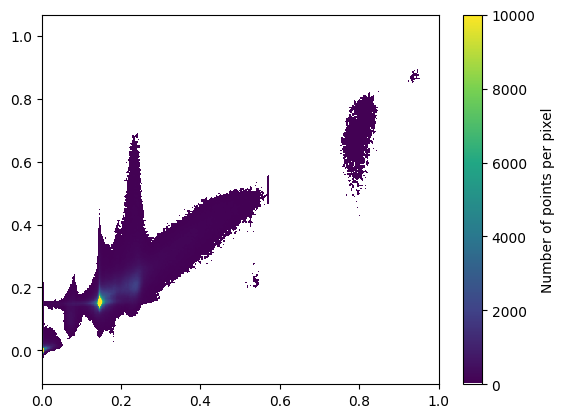

In [241]:
#y_test = y_test.to_numpy()

fig = plt.figure()

white_viridis = LinearSegmentedColormap.from_list('white_viridis', [
    (0, '#ffffff'),
    (1e-20, '#440053'),
    (0.2, '#404388'),
    (0.4, '#2a788e'),
    (0.6, '#21a784'),
    (0.8, '#78d151'),
    (1, '#fde624'),
], N=256)

ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
density = ax.scatter_density(y_test, y_pred, cmap=white_viridis, vmin=0, vmax=10000)
fig.colorbar(density, label='Number of points per pixel')
plt.show()

## Map best performer for SD:

In [170]:
#First we need to pick a day to map:

test = pd.read_parquet('test_scaled_LatLonDateUnscaled.parquet')

In [190]:
test1 = test[test['date'] <= '2020-11-1'] #All records up to our map day

latlon1 = latlon_setup(test1, 30)
print(latlon1.head()) #Maximum possible pixels.

testdate = test[test['date'] == '2020-11-1'] #our y_test, essentially.
print("Length of testdate: ", len(testdate))
print(testdate.head()) #The list of pixels present on map day

#Only keep pixels on testdate that are also present in latlon1:
testdate = pd.merge(testdate, latlon1, how = 'inner', on = ['lat', 'lon'])
latlon1 = pd.merge(latlon1, testdate, how = 'inner', on = ['lat', 'lon'])
print("Length of testdate after merge: ", len(testdate))
print(testdate.head())
print("Final len testdate: ", len(testdate)) #80: 19681, 30: 42596
print("Final len latlon1: ", len(latlon1))

Length of df of unique latlon paris that meet cutoff:  153229
              lat        lon
139568  65.905140   95.74170
5627    33.165960   78.56328
96845   58.551846  131.31224
115202  61.636730 -150.17116
73378   55.222220  -76.41598
Length of testdate:  58314
           density  snowtemp  soiltemp     omega       Tbh       Tbv  \
30586952  0.170206  0.708772  0.845780  0.681356  0.705369  0.713866   
30586953  0.167071  0.730467  0.868891  0.680220  0.688666  0.689544   
30586954  0.159643  0.697934  0.845582  0.680000  0.690524  0.704247   
30586955  0.170206  0.708772  0.857352  0.681035  0.701983  0.712883   
30586956  0.174646  0.704454  0.869552  0.700000  0.698099  0.709491   

                cf         h       voc        lat        lon       date  
30586952  0.323790  0.090114  0.064464  65.565310 -179.95332 2020-11-01  
30586953  0.322650  0.085397  0.004672  65.229836 -179.95332 2020-11-01  
30586954  0.314897  0.095943  0.068366  65.734665 -179.85995 2020-11-01  
30586955

In [218]:
def gen_np_last(df, n_input):
  """Produces last possible window of n_input historical records of data from the provided dataframe."""
  Xs, ys = [], []
  current_slice = df.iloc[len(df)-n_input:]
  X = current_slice[['snowtemp', 'soiltemp', 'omega', 'Tbh', 'Tbv', 'cf', 'h']].values
  y = current_slice[['density', 'voc']].values[-1]
  Xs.append(X)
  ys.append(y)
  X = np.stack(Xs)
  y = np.stack(ys)
  return X, y

In [222]:
#Iterate though test and grab the LAST possible sample set of length n_length, such that the last X values and the corresponding y values are in testdate.
def data_prep_last_only(bigdf, latlon, path, n_input, n_features, X, y, counter = 0, savept = 0):
    start = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
    print("Started at: ", start)
    for i in range(len(latlon)-counter): #Iterate though our set of viable lat/lons, minus counter to restart if needed.
      counter += 1
      df = bigdf[(bigdf['lat'] == latlon['lat'].iloc[i]) & (bigdf['lon'] == latlon['lon'].iloc[i])] #Make a sub df of each lat/lon pair
      df = df.sort_values(by = 'date') #Make sure we have our values correctly ordered
      #print("Len of sub df: ", len(df))
      X2, y2 = gen_np_last(df, n_input) #Make your arrays, in this case only last possible array such that they end on a specific date.
      #print("Dimensions of X and y: ", X.shape, y.shape)
      #print("Dimensions of X2 and y2: ", X2.shape, y2.shape)
      X = np.vstack([X, X2]) #Append your arrays
      y = np.concatenate([y, y2])
      if counter%1000 == 0: #For every thousand lat/long pairs check point
        print("Counter: ", counter, ", Shape X: ", X.shape, time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
        with open((path + str(savept) + '.npy'), 'wb') as f: #Saves two arrays in same file, arrays can be opened separately.
          np.save(f, X)
          np.save(f, y)
        print("Wipeout: ", savept)
        savept += 1
        X = np.empty([0, n_input, n_features])
        y = np.empty([0,2])
    print("Save last: ")
    with open((path + '_last.npy'), 'wb') as f: #final save of X,y to grab any remaining lat/lon pairs since last checkpoint:
          np.save(f, X)
          np.save(f, y)
    print("Done! And it only took from ", start, " to ", time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))


In [223]:
n_input = 30
n_features = 7
X = np.empty([0, n_input, n_features])
y = np.empty([0,2])
#print(X.shape)
#print(y.shape)
path = 'LSTM_Map_30'
counter = 0
savept = 0
data_prep_last_only(test1, latlon1, path, n_input, n_features, X, y, counter, savept)

Started at:  2022-12-21 16:39:34
Counter:  1000 , Shape X:  (1000, 30, 7) 2022-12-21 16:40:01
Wipeout:  0
Counter:  2000 , Shape X:  (1000, 30, 7) 2022-12-21 16:40:25
Wipeout:  1
Counter:  3000 , Shape X:  (1000, 30, 7) 2022-12-21 16:40:50
Wipeout:  2
Counter:  4000 , Shape X:  (1000, 30, 7) 2022-12-21 16:41:15
Wipeout:  3
Counter:  5000 , Shape X:  (1000, 30, 7) 2022-12-21 16:41:39
Wipeout:  4
Counter:  6000 , Shape X:  (1000, 30, 7) 2022-12-21 16:42:06
Wipeout:  5
Counter:  7000 , Shape X:  (1000, 30, 7) 2022-12-21 16:42:38
Wipeout:  6
Counter:  8000 , Shape X:  (1000, 30, 7) 2022-12-21 16:43:09
Wipeout:  7
Counter:  9000 , Shape X:  (1000, 30, 7) 2022-12-21 16:43:34
Wipeout:  8
Counter:  10000 , Shape X:  (1000, 30, 7) 2022-12-21 16:43:59
Wipeout:  9
Counter:  11000 , Shape X:  (1000, 30, 7) 2022-12-21 16:44:24
Wipeout:  10
Counter:  12000 , Shape X:  (1000, 30, 7) 2022-12-21 16:44:49
Wipeout:  11
Counter:  13000 , Shape X:  (1000, 30, 7) 2022-12-21 16:45:14
Wipeout:  12
Counter:  1

In [224]:
X_map = np.empty([0, n_input, n_features])
y_map = np.empty([0, 2])
path = 'LSTM_Map_30'
X_map, y_map = assemble_test(X_map, y_map, path)

print(X_map.shape)
print(y_map.shape)
print(y_map[0:5])

Test:  <_io.BufferedReader name='LSTM_Map_30\\LSTM_Map_300.npy'> (1000, 30, 7)
Test:  <_io.BufferedReader name='LSTM_Map_30\\LSTM_Map_301.npy'> (2000, 30, 7)
Test:  <_io.BufferedReader name='LSTM_Map_30\\LSTM_Map_3010.npy'> (3000, 30, 7)
Test:  <_io.BufferedReader name='LSTM_Map_30\\LSTM_Map_3011.npy'> (4000, 30, 7)
Test:  <_io.BufferedReader name='LSTM_Map_30\\LSTM_Map_3012.npy'> (5000, 30, 7)
Test:  <_io.BufferedReader name='LSTM_Map_30\\LSTM_Map_3013.npy'> (6000, 30, 7)
Test:  <_io.BufferedReader name='LSTM_Map_30\\LSTM_Map_3014.npy'> (7000, 30, 7)
Test:  <_io.BufferedReader name='LSTM_Map_30\\LSTM_Map_3015.npy'> (8000, 30, 7)
Test:  <_io.BufferedReader name='LSTM_Map_30\\LSTM_Map_3016.npy'> (9000, 30, 7)
Test:  <_io.BufferedReader name='LSTM_Map_30\\LSTM_Map_3017.npy'> (10000, 30, 7)
Test:  <_io.BufferedReader name='LSTM_Map_30\\LSTM_Map_3018.npy'> (11000, 30, 7)
Test:  <_io.BufferedReader name='LSTM_Map_30\\LSTM_Map_3019.npy'> (12000, 30, 7)
Test:  <_io.BufferedReader name='LSTM_M

In [225]:
y_pred_map = model.predict(X_map, batch_size=batch_size, callbacks=callbacks_list, verbose=1)

86/86 [==============================] - 11s 123ms/step


In [226]:
y_map_unscaled = scaler.inverse_transform(y_map)
print(y_map_unscaled[0:5])

y_pred_map_unscaled = scaler.inverse_transform(y_pred_map)
print(y_pred_map_unscaled[0:5])

print("Metrics for nov 1st 2020 map, unscaled:")
get_metrics(y_map_unscaled, y_pred_map_unscaled)

[[127.03410623   0.        ]
 [150.33098846   0.38223145]
 [151.09161033   0.2956255 ]
 [150.15563151   0.        ]
 [150.16386528   0.        ]]
[[ 1.5168173e+02 -5.5694939e-03]
 [ 1.6618825e+02  4.9331778e-01]
 [ 1.5827963e+02  5.6985205e-01]
 [ 1.5202991e+02 -8.3786920e-03]
 [ 1.5320758e+02  1.5642662e-03]]
Metrics for nov 1st 2020 map, unscaled:
Snow Density Performance: 
MAE:  15.512991386137019
MSE:  632.1912049561365
RMSE:  25.143412754758184
R2:  -8.249986264118114
VOD Performance: 
MAE:  0.09984018913600672
MSE:  0.0373749916649063
RMSE:  0.193326127734733
R2:  0.44039249162382144


(15.512991386137019,
 632.1912049561365,
 25.143412754758184,
 -8.249986264118114,
 0.09984018913600672,
 0.0373749916649063,
 0.193326127734733,
 0.44039249162382144)

In [229]:
#Now merge back with latlon:
latlon1['density_unscaled'] = y_map_unscaled[:,0]
latlon1['VOD_unscaled'] = y_map_unscaled[:,1]
latlon1['density_pred_unscaled'] = y_pred_map_unscaled[:,0]
latlon1['VOD_pred_unscaled'] = y_pred_map_unscaled[:,1]
latlon1.head()

,lat,lon,density,snowtemp,soiltemp,omega,Tbh,Tbv,cf,h,voc,date,snow density,density_unscaled,VOD_unscaled,density_pred_unscaled,VOD_pred_unscaled
0,33.165960,78.563280,0.077240,0.639721,0.885132,0.000000,0.684257,0.696721,0.207921,0.114647,0.000000,2020-11-01,127.034106,127.034106,0.000000,151.681732,-0.005569
1,50.799440,110.306015,0.143803,0.803512,0.878953,0.702479,0.731068,0.726857,0.256997,0.040906,0.254843,2020-11-01,150.330988,150.330988,0.382231,166.188248,0.493318
2,52.377525,101.530080,0.145976,0.734173,0.992591,0.704958,0.726729,0.720115,0.221864,0.143078,0.197100,2020-11-01,151.091610,151.091610,0.295626,158.279633,0.569852
3,33.250010,80.803940,0.143302,0.689974,0.950213,0.000000,0.667114,0.702663,0.208257,0.074864,0.000000,2020-11-01,150.155632,150.155632,0.000000,152.029907,-0.008379
4,34.605970,87.245850,0.143325,0.707016,0.865505,0.196491,0.650340,0.699951,0.316629,0.042201,0.000000,2020-11-01,150.163865,150.163865,0.000000,153.207581,0.001564


In [230]:
latlon1.to_parquet('LSTM_Map_30/LSTM_Map_30_pred.parquet')

## Map Best performer for VOD:

In [231]:
test1 = test[test['date'] <= '2020-11-1']  #All records up to our map day

latlon1 = latlon_setup(test1, 80) #For VOD we use the n_input = 80 length, as this was the best performer.
print(latlon1.head())  #Maximum possible pixels.

testdate = test[test['date'] == '2020-11-1']  #our y_test, essentially.
print("Length of testdate: ", len(testdate))
print(testdate.head())  #The list of pixels present on map day

#Only keep pixels on testdate that are also present in latlon1:
testdate = pd.merge(testdate, latlon1, how='inner', on=['lat', 'lon'])
latlon1 = pd.merge(latlon1, testdate, how='inner', on=['lat', 'lon'])
print("Length of testdate after merge: ", len(testdate))
print(testdate.head())
print("Final len testdate: ", len(testdate))  #80: 19681, 30: 42596
print("Final len latlon1: ", len(latlon1))

Length of df of unique latlon paris that meet cutoff:  38849
             lat        lon
15565  59.918694 -121.78942
25923  63.144420 -113.38693
28344  63.928204  121.88278
21260  61.636730  127.76453
33127  65.734665 -139.34130
Length of testdate:  58314
           density  snowtemp  soiltemp     omega       Tbh       Tbv  \
30586952  0.170206  0.708772  0.845780  0.681356  0.705369  0.713866   
30586953  0.167071  0.730467  0.868891  0.680220  0.688666  0.689544   
30586954  0.159643  0.697934  0.845582  0.680000  0.690524  0.704247   
30586955  0.170206  0.708772  0.857352  0.681035  0.701983  0.712883   
30586956  0.174646  0.704454  0.869552  0.700000  0.698099  0.709491   

                cf         h       voc        lat        lon       date  
30586952  0.323790  0.090114  0.064464  65.565310 -179.95332 2020-11-01  
30586953  0.322650  0.085397  0.004672  65.229836 -179.95332 2020-11-01  
30586954  0.314897  0.095943  0.068366  65.734665 -179.85995 2020-11-01  
30586955  0.336

In [232]:
n_input = 80
n_features = 7
X = np.empty([0, n_input, n_features])
y = np.empty([0, 2])
#print(X.shape)
#print(y.shape)
path = 'LSTM_Map_80/LSTM_Map_Data_80_'
counter = 0
savept = 0
data_prep_last_only(test1, latlon1, path, n_input, n_features, X, y, counter, savept)

Started at:  2022-12-21 17:53:01
Counter:  1000 , Shape X:  (1000, 80, 7) 2022-12-21 17:53:30
Wipeout:  0
Counter:  2000 , Shape X:  (1000, 80, 7) 2022-12-21 17:54:02
Wipeout:  1
Counter:  3000 , Shape X:  (1000, 80, 7) 2022-12-21 17:54:30
Wipeout:  2
Counter:  4000 , Shape X:  (1000, 80, 7) 2022-12-21 17:54:57
Wipeout:  3
Counter:  5000 , Shape X:  (1000, 80, 7) 2022-12-21 17:55:23
Wipeout:  4
Counter:  6000 , Shape X:  (1000, 80, 7) 2022-12-21 17:55:50
Wipeout:  5
Counter:  7000 , Shape X:  (1000, 80, 7) 2022-12-21 17:56:18
Wipeout:  6
Counter:  8000 , Shape X:  (1000, 80, 7) 2022-12-21 17:56:47
Wipeout:  7
Counter:  9000 , Shape X:  (1000, 80, 7) 2022-12-21 17:57:15
Wipeout:  8
Counter:  10000 , Shape X:  (1000, 80, 7) 2022-12-21 17:57:41
Wipeout:  9
Counter:  11000 , Shape X:  (1000, 80, 7) 2022-12-21 17:58:09
Wipeout:  10
Counter:  12000 , Shape X:  (1000, 80, 7) 2022-12-21 17:58:38
Wipeout:  11
Counter:  13000 , Shape X:  (1000, 80, 7) 2022-12-21 17:59:13
Wipeout:  12
Counter:  1

In [233]:
X_map2 = np.empty([0, n_input, n_features])
y_map2 = np.empty([0, 2])
path = 'LSTM_Map_80'
X_map2, y_map2 = assemble_test(X_map2, y_map2, path)

print(X_map2.shape)
print(y_map2.shape)
print(y_map2[0:5])

Test:  <_io.BufferedReader name='LSTM_Map_80\\LSTM_Map_Data_80_0.npy'> (1000, 80, 7)
Test:  <_io.BufferedReader name='LSTM_Map_80\\LSTM_Map_Data_80_1.npy'> (2000, 80, 7)
Test:  <_io.BufferedReader name='LSTM_Map_80\\LSTM_Map_Data_80_10.npy'> (3000, 80, 7)
Test:  <_io.BufferedReader name='LSTM_Map_80\\LSTM_Map_Data_80_11.npy'> (4000, 80, 7)
Test:  <_io.BufferedReader name='LSTM_Map_80\\LSTM_Map_Data_80_12.npy'> (5000, 80, 7)
Test:  <_io.BufferedReader name='LSTM_Map_80\\LSTM_Map_Data_80_13.npy'> (6000, 80, 7)
Test:  <_io.BufferedReader name='LSTM_Map_80\\LSTM_Map_Data_80_14.npy'> (7000, 80, 7)
Test:  <_io.BufferedReader name='LSTM_Map_80\\LSTM_Map_Data_80_15.npy'> (8000, 80, 7)
Test:  <_io.BufferedReader name='LSTM_Map_80\\LSTM_Map_Data_80_16.npy'> (9000, 80, 7)
Test:  <_io.BufferedReader name='LSTM_Map_80\\LSTM_Map_Data_80_17.npy'> (10000, 80, 7)
Test:  <_io.BufferedReader name='LSTM_Map_80\\LSTM_Map_Data_80_18.npy'> (11000, 80, 7)
Test:  <_io.BufferedReader name='LSTM_Map_80\\LSTM_Map

In [234]:
model80 = keras.models.load_model("ModelCheckpoints80/model80sparse_final.h5")

In [235]:
y_pred_map2 = model80.predict(X_map2, batch_size=batch_size, callbacks=callbacks_list, verbose=1)

40/40 [==============================] - 16s 366ms/step


In [236]:
y_map2_unscaled = scaler.inverse_transform(y_map2)
print(y_map2_unscaled[0:5])

y_pred_map2_unscaled = scaler.inverse_transform(y_pred_map2)
print(y_pred_map2_unscaled[0:5])

[[1.50692829e+02 3.09363981e-01]
 [1.49846532e+02 2.12720757e-01]
 [1.50396414e+02 2.25796081e-01]
 [1.51145241e+02 2.48168768e-01]
 [1.50235521e+02 9.94682281e-02]]
[[157.51984      0.29612124]
 [152.01326      0.2510319 ]
 [149.27347      0.34343573]
 [153.90227      0.27100435]
 [153.64041      0.30541503]]


In [237]:
print("Metrics for nov 1st 2020 map, unscaled:")
get_metrics(y_map2_unscaled, y_pred_map2_unscaled)

Metrics for nov 1st 2020 map, unscaled:
Snow Density Performance: 
MAE:  19.121790100825795
MSE:  1134.7667102886744
RMSE:  33.68629855428872
R2:  -15.709700858592182
VOD Performance: 
MAE:  0.08992430075433043
MSE:  0.028290506647678224
RMSE:  0.16819781998491604
R2:  0.28307782441189866


(19.121790100825795,
 1134.7667102886744,
 33.68629855428872,
 -15.709700858592182,
 0.08992430075433043,
 0.028290506647678224,
 0.16819781998491604,
 0.28307782441189866)

In [239]:
#Now merge back with latlon:
latlon1['density_unscaled'] = y_map2_unscaled[:, 0]
latlon1['VOD_unscaled'] = y_map2_unscaled[:, 1]
latlon1['density_pred_unscaled'] = y_pred_map2_unscaled[:, 0]
latlon1['VOD_pred_unscaled'] = y_pred_map2_unscaled[:, 1]
latlon1.head()
latlon1.to_parquet('LSTM_Map_80/LSTM_Map_80_pred.parquet')